In [1]:
from n_mirror_cavity_classes_ter import Mirror, Subcavity, Cavity_sym, Cavity_num
from sympy import Symbol, symbols, Derivative
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
sp.init_printing(use_unicode=True)
sp.init_session(quiet=True)
from scipy.signal import find_peaks
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'

In [16]:
def make_length_resonant(input_length, wavelength):
    m = round(2 * input_length / wavelength)
    resonant_length = m * (wavelength / 2)
    return resonant_length

def make_length_antiresonant(input_length, wavelength):
    m = round((2 * input_length / wavelength - 1) / 2)
    resonant_length = (2 * m + 1) * (wavelength / 4)
    return resonant_length

def freq_window(frequencies, phases, f_min=-2.5, f_max=2.8):

    frequencies = np.array(frequencies)
    phases = np.array(phases)

    # Mask to apply the frequency window
    mask = (frequencies >= f_min) & (frequencies <= f_max)
    freqs_window = frequencies[mask]
    phases_window = phases[mask]


    phase_min = np.min(phases_window)
    phase_max = np.max(phases_window)
    norm_phase = (phases_window - phase_min) / (phase_max - phase_min)

    idx_95 = np.argmin(np.abs(norm_phase - 0.80))
    idx_05 = np.argmin(np.abs(norm_phase - 0.20))

    f_95 = freqs_window[idx_95]
    f_05 = freqs_window[idx_05]

    spread = np.abs(f_95 - f_05)

    return f_95, f_05, spread

def find_fwhm(frequencies, values, resonance):
    """Finding FWHM given a frequency array and a resonant frequency in Hz"""
    normalized_values = values / np.max(values)
    idx_peak = np.argmin(np.abs(frequencies - resonance))
    left_idx = idx_peak

    half_max = 0.5

    while left_idx > 0 and normalized_values[left_idx] > half_max:
        left_idx -= 1

    right_idx = idx_peak
    while right_idx < len(normalized_values) and normalized_values[right_idx] > half_max:
        right_idx += 1

    fwhm = frequencies[right_idx] - frequencies[left_idx]
    return fwhm, frequencies[right_idx], frequencies[left_idx]


def find_res(freqs, values):
    values = np.array(values).flatten()
    peaks, _ = find_peaks(values)  # Adjust prominence as neede
# Sort peaks by value (prominence or height) and pick the two largest
    if len(peaks) >= 2:
        sorted_indices = np.argsort(values[peaks])[-2:]  # indices of the two highest peaks
        peak_indices = peaks[sorted_indices]
        peak_indices.sort()  # Sort to get left and right in order

        peak_left = freqs[peak_indices[0]]
        peak_right = freqs[peak_indices[1]]

        return peak_left, peak_right

def find_fsr(freqs, values):
    peaks, _ = find_peaks(values)  # Adjust parameters if needed
    peak_freqs = freqs[peaks] / (2 * np.pi)  # Convert from rad/s to Hz

    if len(peak_freqs) >= 4:
        # First two peak centers
        mid1 = (peak_freqs[0] + peak_freqs[1]) / 2
        mid2 = (peak_freqs[2] + peak_freqs[3]) / 2

        fsr = mid2 - mid1
        return fsr * 1e-6  # in MHz
    else:
        print("Not enough peaks to calculate midpoint-based FSR (need at least 4).")
        return None

In [3]:
t1, t2, t3 = symbols("t1 t2 t3")

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts = [t1, t2, t3]
lambdify_vars = [omega]

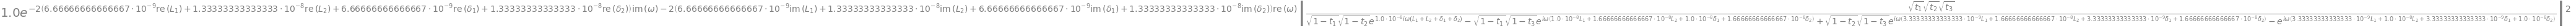

In [4]:
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
cavity_sym = Cavity_sym(mirror_ts, subs_dict)
sp.simplify(cavity_sym.transmitted_power())

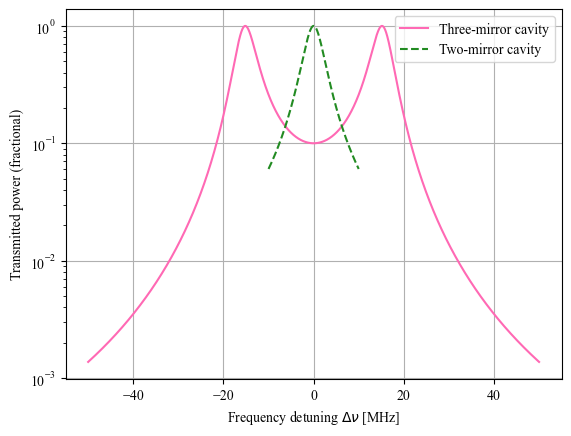

In [44]:
t1, t2, t3 = symbols("t1 t2 t3")

length1 = make_length_resonant(0.5, 1064e-9)
length2 = make_length_resonant(1, 1064e-9)

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts = [t1, t2, t3]
lambdify_vars = [omega]
mirror_vals = {t1: 0.1, t2: 0.1, t3: 0.1}
nu_range = np.linspace(-50e6, 50e6, 10000)
subs_dict_num = {L1: length1, delta1: 0, L2: length1, delta2: 0}
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values, res_1, res_2 = cavity.transmitted_power([nu_range])
plt.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values), label = "Three-mirror cavity", c = "hotpink")

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}]
mirror_ts = [t1, t2]
lambdify_vars = [omega]
mirror_vals = {t1: 0.1, t2: 0.1}
nu_range = np.linspace(-10e6, 10e6, 10000)
subs_dict_num = {L1: length2, delta1: 0}
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values, _, _ = cavity.transmitted_power([nu_range])
plt.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values), label = "Two-mirror cavity", c = "forestgreen", linestyle = "dashed")


plt.yscale("log")
plt.grid()
plt.xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
plt.ylabel("Transmitted power (fractional)")
plt.legend()
plt.show()

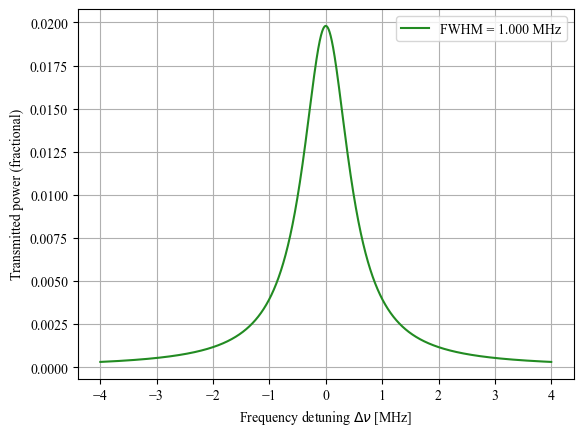

In [135]:
L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}]
mirror_ts = [t1, t2]
lambdify_vars = [omega]
mirror_vals = {t1: 5e-7, t2: 10e-5}
nu_range = np.linspace(-4e6, 4e6, 100000)
subs_dict_num = {L1: 0.0024, delta1: 0}
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values, _, _ = cavity.transmitted_power([nu_range])
fwhm, left, right = find_fwhm(ranges, values, 0)
fwhm_label = fwhm / (2 * np.pi) * 1e-6
plt.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values), label = "FWHM = " + f"{fwhm_label:.3f}" + " MHz", c = "forestgreen")
# plt.axvline(left / (2 * np.pi) * 1e-6)
# plt.axvline(right/ (2 * np.pi) * 1e-6)

# plt.yscale("log")
plt.grid()
plt.xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
plt.ylabel("Transmitted power (fractional)")
plt.legend()
plt.show()

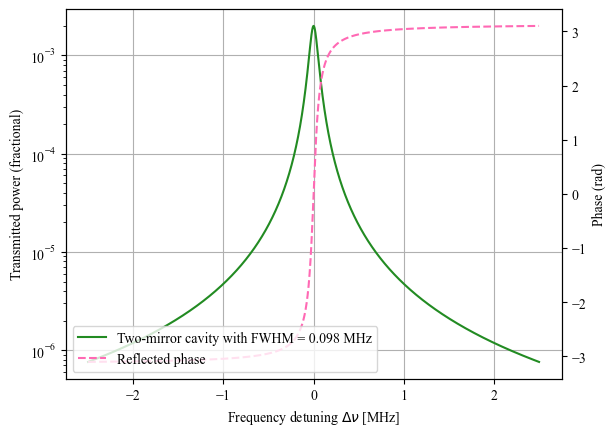

In [269]:
L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}]
mirror_ts = [t1, t2]
lambdify_vars = [omega]
mirror_vals = {t1: 2000e-6, t2: 1e-6}
nu_range = np.linspace(-2.5e6, 2.5e6, 100000)
subs_dict_num = {L1: 0.49, delta1: 0}

cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values, _, _ = cavity.transmitted_power([nu_range])
fwhm, left, right = find_fwhm(ranges, values, 0)
fwhm_label = fwhm / (2 * np.pi) * 1e-6

phase_range, phase, _ = cavity.phase_response_reflected([nu_range])

# Create dual axis plot
fig, ax1 = plt.subplots()

# Left axis: Transmission (log scale)
ax1.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values),
         label=f"Two-mirror cavity with FWHM = {fwhm_label:.3f} MHz", color="forestgreen")
ax1.set_xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
ax1.set_ylabel("Transmitted power (fractional)")
ax1.set_yscale("log")
ax1.grid()

# Right axis: Phase (linear)
ax2 = ax1.twinx()
ax2.plot(ranges / (2 * np.pi) * 1e-6, phase, color="hotpink", label="Reflected phase", linestyle = "dashed")
ax2.set_ylabel("Phase (rad)")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

plt.show()


In [307]:
t1, t2, t3 = symbols("t1 t2 t3")

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts = [t1, t2, t3]
lambdify_vars = [omega]
mirror_vals = {t1: 0.005, t2: 0.01, t3: 1e-6}
nu_range = np.linspace(-20e6, 20e6, 10000)


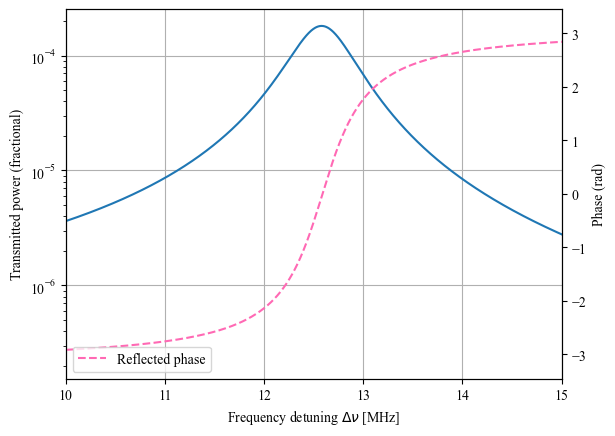

In [308]:
subs_dict_num = {L1: 0.09, delta1: 0, L2: 0.4, delta2: 0}
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values, res_1, res_2 = cavity.transmitted_power([nu_range])
phase_range, phase, _ = cavity.phase_response_reflected([nu_range])

fig, ax1 = plt.subplots()

# Left axis: Transmission (log scale)
ax1.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values))
ax1.set_xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
ax1.set_ylabel("Transmitted power (fractional)")
ax1.set_yscale("log")
ax1.grid()

# Right axis: Phase (linear)
ax2 = ax1.twinx()
ax2.plot(ranges / (2 * np.pi) * 1e-6, phase, color="hotpink", label="Reflected phase", linestyle = "dashed")
ax2.set_ylabel("Phase (rad)")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower left")
plt.xlim(10, 15)
plt.show()

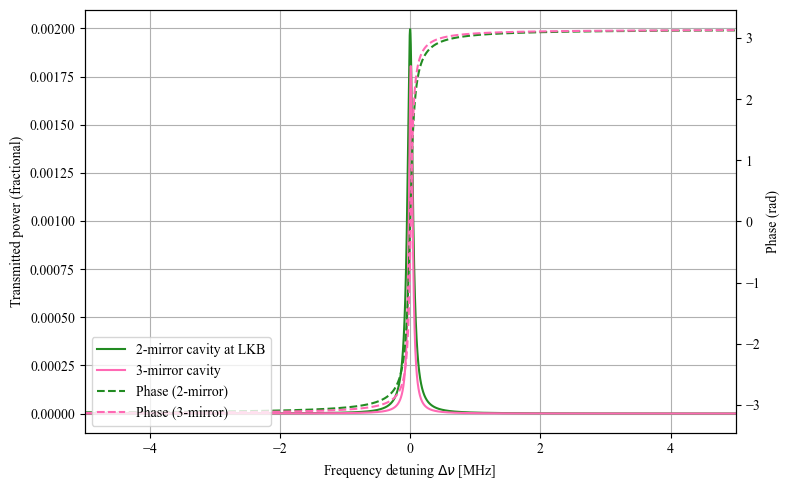

In [6]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# --- Two-mirror cavity setup ---
L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict_2m = [{L: L1, delta: delta1}]
mirror_ts_2m = [t1, t2]
lambdify_vars = [omega]
mirror_vals_2m = {t1: 2000e-6, t2: 1e-6}
subs_dict_num_2m = {L1: 0.49, delta1: 0}
nu_range_2m = np.linspace(-5e6, 5e6, 100000)

cavity_2m = Cavity_num(mirror_ts_2m, mirror_vals_2m, subs_dict_2m, subs_dict_num_2m, lambdify_vars)
ranges_2m, values_2m, *_ = cavity_2m.transmitted_power([nu_range_2m])
fwhm_2m, _, _ = find_fwhm(ranges_2m, values_2m, 0)
fwhm_label = fwhm_2m / (2 * np.pi) * 1e-6
phase_range_2m, phase_2m, _ = cavity_2m.phase_response_reflected([nu_range_2m])

freqs_2m = ranges_2m / (2 * np.pi) * 1e-6
ax1.plot(freqs_2m, np.abs(values_2m), label=f"2-mirror cavity at LKB", color="forestgreen")

# --- Three-mirror cavity setup ---
t1, t2, t3 = symbols("t1 t2 t3")
subs_dict_3m = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts_3m = [t1, t2, t3]
mirror_vals_3m = {t1: 0.0005, t2: 0.01, t3: 1e-6}
subs_dict_num_3m = {L1: 0.09, delta1: 0, L2: 0.4, delta2: 0}
nu_range_3m = np.linspace(-20e6, 20e6, 10000)

cavity_3m = Cavity_num(mirror_ts_3m, mirror_vals_3m, subs_dict_3m, subs_dict_num_3m, lambdify_vars)
ranges_3m, values_3m, _, _ = cavity_3m.transmitted_power([nu_range_3m])
phase_range_3m, phase_3m, _ = cavity_3m.phase_response_reflected([nu_range_3m])

freqs_3m = ranges_3m / (2 * np.pi) * 1e-6
ax1.plot(freqs_3m  - 12.579257925792577, np.abs(values_3m), label="3-mirror cavity", color="hotpink")

# Left axis: formatting
ax1.set_xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
ax1.set_ylabel("Transmitted power (fractional)")
# ax1.set_yscale("log")
ax1.grid(True)

# Right axis: reflected phase
ax2 = ax1.twinx()
ax2.plot(freqs_2m, phase_2m, color="forestgreen", linestyle="dashed", label="Phase (2-mirror)")
ax2.plot(freqs_3m  - 12.579257925792577, phase_3m, color="hotpink", linestyle="dashed", label="Phase (3-mirror)")
ax2.set_ylabel("Phase (rad)")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

# Optional: zoom into region of interest (adjust as needed)
plt.xlim(-5, 5)
plt.tight_layout()
plt.show()


2-mirror FWHM: 0.10 MHz
2-mirror phase window: 0.13 MHz between -0.07 and 0.07 MHz
3-mirror FWHM: 0.07 MHz
3-mirror phase window: 0.09 MHz between -0.04 and 0.06 MHz


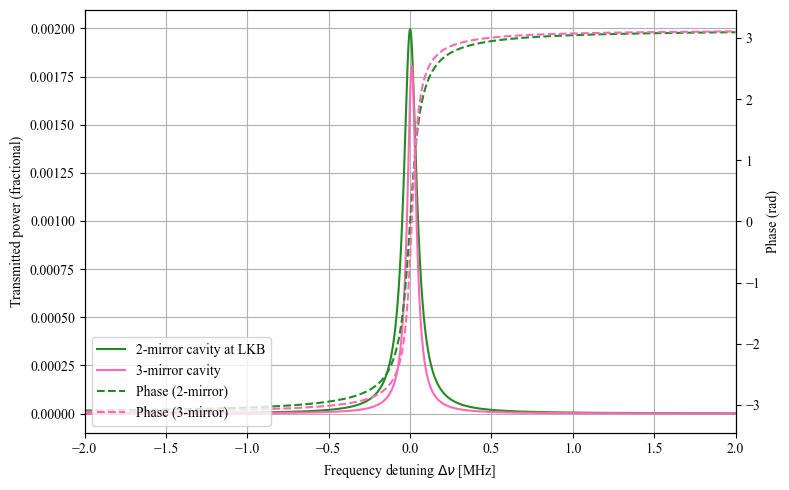

In [17]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# --- Two-mirror cavity ---
L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
t1, t2, t3 = symbols("t1 t2 t3")

subs_dict_2m = [{L: L1, delta: delta1}]
mirror_ts_2m = [t1, t2]
lambdify_vars = [omega]
mirror_vals_2m = {t1: 2000e-6, t2: 1e-6}
subs_dict_num_2m = {L1: 0.49, delta1: 0}
nu_range_2m = np.linspace(-5e6, 5e6, 100000)

cavity_2m = Cavity_num(mirror_ts_2m, mirror_vals_2m, subs_dict_2m, subs_dict_num_2m, lambdify_vars)
ranges_2m, values_2m, *_ = cavity_2m.transmitted_power([nu_range_2m])
phase_range_2m, phase_2m, _ = cavity_2m.phase_response_reflected([nu_range_2m])
freqs_2m = ranges_2m / (2 * np.pi) * 1e-6

# --- FWHM and Phase Window for 2-mirror ---
fwhm_2m, _, _ = find_fwhm(ranges_2m, values_2m, 0)
fwhm_label = fwhm_2m / (2 * np.pi) * 1e-6
f_95_2m, f_05_2m, spread_2m = freq_window(freqs_2m, phase_2m, f_min=-5, f_max=5)
print(f"2-mirror FWHM: {fwhm_label:.2f} MHz")
print(f"2-mirror phase window: {spread_2m:.2f} MHz between {f_05_2m:.2f} and {f_95_2m:.2f} MHz")

# --- Three-mirror cavity ---
subs_dict_3m = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts_3m = [t1, t2, t3]
mirror_vals_3m = {t1: 0.0005, t2: 0.01, t3: 1e-6}
subs_dict_num_3m = {L1: 0.09, delta1: 0, L2: 0.4, delta2: 0}
nu_range_3m = np.linspace(-20e6, 20e6, 10000)

cavity_3m = Cavity_num(mirror_ts_3m, mirror_vals_3m, subs_dict_3m, subs_dict_num_3m, lambdify_vars)
ranges_3m, values_3m, _, _ = cavity_3m.transmitted_power([nu_range_3m])
phase_range_3m, phase_3m, _ = cavity_3m.phase_response_reflected([nu_range_3m])
freqs_3m = ranges_3m / (2 * np.pi) * 1e-6

# --- FWHM and Phase Window for 3-mirror ---
resonance_freq_3m = ranges_3m[np.argmax(np.abs(values_3m))]
fwhm_3m, _, _ = find_fwhm(ranges_3m, np.abs(values_3m), resonance_freq_3m)
fwhm_label_3m = fwhm_3m / (2 * np.pi) * 1e-6
f_95_3m, f_05_3m, spread_3m = freq_window(freqs_3m - 12.579257925792577, phase_3m, f_min=-5, f_max=5)
print(f"3-mirror FWHM: {fwhm_label_3m:.2f} MHz")
print(f"3-mirror phase window: {spread_3m:.2f} MHz between {f_05_3m:.2f} and {f_95_3m:.2f} MHz")

# === Plot ===
ax1.plot(freqs_2m, np.abs(values_2m), label=f"2-mirror cavity at LKB", color="forestgreen")
ax1.plot(freqs_3m - 12.579257925792577, np.abs(values_3m), label="3-mirror cavity", color="hotpink")

ax1.set_xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
ax1.set_ylabel("Transmitted power (fractional)")
# ax1.set_yscale("log")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(freqs_2m, phase_2m, color="forestgreen", linestyle="dashed", label="Phase (2-mirror)")
ax2.plot(freqs_3m - 12.579257925792577, phase_3m, color="hotpink", linestyle="dashed", label="Phase (3-mirror)")
ax2.set_ylabel("Phase (rad)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

plt.xlim(-2, 2)
plt.tight_layout()
plt.show()


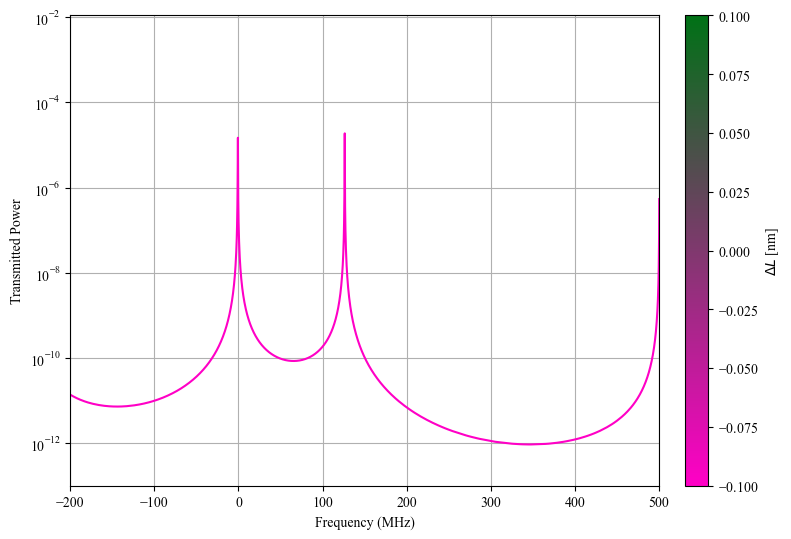

In [396]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case
mirror_vals = {t1: 0.0005, t2: 0.01, t3: 1e-6}

length_subcavity_1 = make_length_resonant(0.1, 1064e-9)
length_subcavity_2 = make_length_resonant(0.9, 1064e-9)

# Parameter sweep
dL = np.linspace(0, 531e-9, 1)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-10000e6, laser_freq+10000e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm

# Color normalization and colorbar for nanometers
norm = mcolors.Normalize(vmin=dL_nm.min(), vmax=dL_nm.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
fwhm_arr = []

colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, d in enumerate(dL):
    subs_dict_num = {L1: 0.09, delta1: 0, L2: 0.4, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values= cavity.transmitted_power_no_comp([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values), color=colors[idx])
    # Convert frequency to MHz for easier window definition
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000

ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
# ax.set_title("MATE setup: t1=0.1, t2=0.1, t3=1ppm")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$\Delta L$ [nm]")

plt.tight_layout()
plt.grid(which="both")
plt.xlim(-200, 500)
# plt.ylim(0, 0.000035)
# plt.savefig("transmission_MAME_dl.svg", transparent=True, dpi=300)
plt.show()

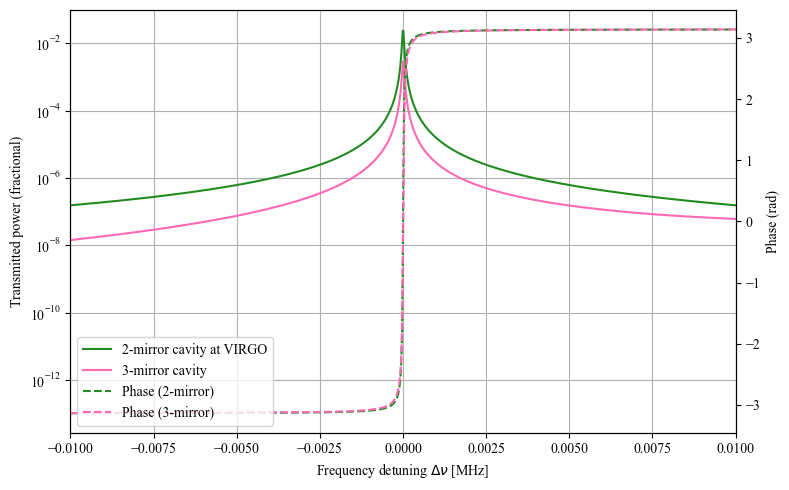

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# --- Two-mirror cavity setup ---
L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict_2m = [{L: L1, delta: delta1}]
mirror_ts_2m = [t1, t2]
lambdify_vars = [omega]
mirror_vals_2m = {t1: 562e-6, t2: 3.9e-6}
subs_dict_num_2m = {L1: 284.9, delta1: 0}
nu_range_2m = np.linspace(-1e6, 1e6, 100000)

cavity_2m = Cavity_num(mirror_ts_2m, mirror_vals_2m, subs_dict_2m, subs_dict_num_2m, lambdify_vars)
ranges_2m, values_2m, *_ = cavity_2m.transmitted_power([nu_range_2m])
fwhm_2m, _, _ = find_fwhm(ranges_2m, values_2m, 0)
fwhm_label = fwhm_2m / (2 * np.pi) * 1e-6
phase_range_2m, phase_2m, _ = cavity_2m.phase_response_reflected([nu_range_2m])

freqs_2m = ranges_2m / (2 * np.pi) * 1e-6
ax1.plot(freqs_2m, np.abs(values_2m), label=f"2-mirror cavity at Advanced Virgo", color="forestgreen")

# --- Three-mirror cavity setup ---
t1, t2, t3 = symbols("t1 t2 t3")
subs_dict_3m = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts_3m = [t1, t2, t3]
mirror_vals_3m = {t1: 50e-6, t2: 0.001, t3: 1e-6}
subs_dict_num_3m = {L1: 10, delta1: 0, L2: 274.9, delta2: 0}
nu_range_3m = np.linspace(-1e6, 1e6, 100000)

cavity_3m = Cavity_num(mirror_ts_3m, mirror_vals_3m, subs_dict_3m, subs_dict_num_3m, lambdify_vars)
ranges_3m, values_3m, res_1, _ = cavity_3m.transmitted_power([nu_range_3m])
phase_range_3m, phase_3m, _ = cavity_3m.phase_response_reflected([nu_range_3m])

freqs_3m = ranges_3m / (2 * np.pi) * 1e-6
ax1.plot(freqs_3m - res_1 / (2*np.pi) * 1e-6, np.abs(values_3m), label="3-mirror cavity", color="hotpink")

# Left axis: formatting
ax1.set_xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
ax1.set_ylabel("Transmitted power (fractional)")
ax1.set_yscale("log")
ax1.grid(True)

# Right axis: reflected phase
ax2 = ax1.twinx()
ax2.plot(freqs_2m, phase_2m, color="forestgreen", linestyle="dashed", label="Phase (2-mirror)")
ax2.plot(freqs_3m - res_1 / (2*np.pi) * 1e-6, phase_3m, color="hotpink", linestyle="dashed", label="Phase (3-mirror)")
ax2.set_ylabel("Phase (rad)")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

# Optional: zoom into region of interest (adjust as needed)
plt.xlim(-0.01, 0.01)
plt.tight_layout()
plt.show()


2-mirror FWHM: 0.0000600 MHz
2-mirror phase window: 0.0000600 MHz between -0.0000300 and 0.0000300 MHz
3-mirror FWHM: 0.0000800 MHz
3-mirror phase window: 0.0000800 MHz between -0.0000400 and 0.0000400 MHz


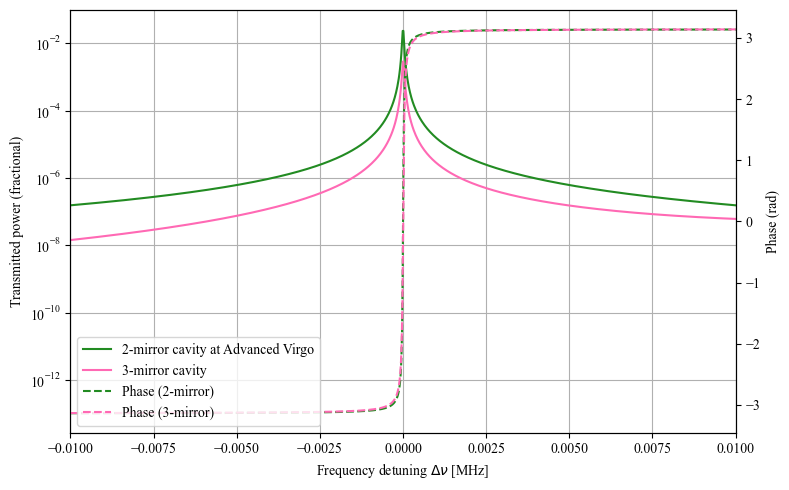

In [19]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# --- Two-mirror cavity setup ---
L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
t1, t2, t3 = symbols("t1 t2 t3")  # symbols for mirrors

subs_dict_2m = [{L: L1, delta: delta1}]
mirror_ts_2m = [t1, t2]
lambdify_vars = [omega]
mirror_vals_2m = {t1: 562e-6, t2: 3.9e-6}
subs_dict_num_2m = {L1: 284.9, delta1: 0}
nu_range_2m = np.linspace(-1e6, 1e6, 100000)

cavity_2m = Cavity_num(mirror_ts_2m, mirror_vals_2m, subs_dict_2m, subs_dict_num_2m, lambdify_vars)
ranges_2m, values_2m, *_ = cavity_2m.transmitted_power([nu_range_2m])
phase_range_2m, phase_2m, _ = cavity_2m.phase_response_reflected([nu_range_2m])

freqs_2m = ranges_2m / (2 * np.pi) * 1e-6
ax1.plot(freqs_2m, np.abs(values_2m), label=f"2-mirror cavity at Advanced Virgo", color="forestgreen")

# --- Calculate FWHM and phase window (2-mirror) ---
fwhm_2m, _, _ = find_fwhm(ranges_2m, values_2m, 0)
fwhm_label_2m = fwhm_2m / (2 * np.pi) * 1e-6
f_95_2m, f_05_2m, spread_2m = freq_window(freqs_2m, phase_2m, f_min=-0.01, f_max=0.01)

print(f"2-mirror FWHM: {fwhm_label_2m:.7f} MHz")
print(f"2-mirror phase window: {spread_2m:.7f} MHz between {f_05_2m:.7f} and {f_95_2m:.7f} MHz")

# --- Three-mirror cavity setup ---
subs_dict_3m = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts_3m = [t1, t2, t3]
mirror_vals_3m = {t1: 50e-6, t2: 0.001, t3: 1e-6}
subs_dict_num_3m = {L1: 10, delta1: 0, L2: 274.9, delta2: 0}
nu_range_3m = np.linspace(-1e6, 1e6, 100000)

cavity_3m = Cavity_num(mirror_ts_3m, mirror_vals_3m, subs_dict_3m, subs_dict_num_3m, lambdify_vars)
ranges_3m, values_3m, res_1, _ = cavity_3m.transmitted_power([nu_range_3m])
phase_range_3m, phase_3m, _ = cavity_3m.phase_response_reflected([nu_range_3m])

freqs_3m = ranges_3m / (2 * np.pi) * 1e-6
detuning_offset = res_1 / (2 * np.pi) * 1e-6  # for zero-centering

ax1.plot(freqs_3m - detuning_offset, np.abs(values_3m), label="3-mirror cavity", color="hotpink")

# --- Calculate FWHM and phase window (3-mirror) ---
res_freq_3m = ranges_3m[np.argmax(values_3m)]
fwhm_3m, _, _ = find_fwhm(ranges_3m, values_3m, res_freq_3m)
fwhm_label_3m = fwhm_3m / (2 * np.pi) * 1e-6
f_95_3m, f_05_3m, spread_3m = freq_window(freqs_3m - detuning_offset, phase_3m, f_min=-0.01, f_max=0.01)

print(f"3-mirror FWHM: {fwhm_label_3m:.7f} MHz")
print(f"3-mirror phase window: {spread_3m:.7f} MHz between {f_05_3m:.7f} and {f_95_3m:.7f} MHz")

# --- Plot formatting ---
ax1.set_xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
ax1.set_ylabel("Transmitted power (fractional)")
ax1.set_yscale("log")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(freqs_2m, phase_2m, color="forestgreen", linestyle="dashed", label="Phase (2-mirror)")
ax2.plot(freqs_3m - detuning_offset, phase_3m, color="hotpink", linestyle="dashed", label="Phase (3-mirror)")
ax2.set_ylabel("Phase (rad)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

plt.xlim(-0.01, 0.01)
plt.tight_layout()
plt.show()


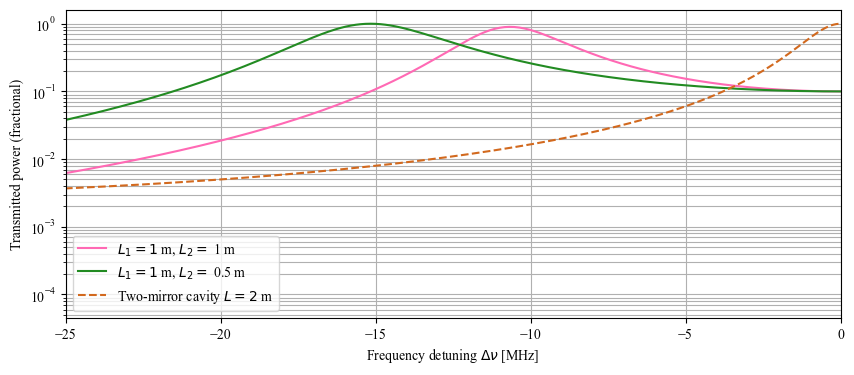

In [452]:
t1, t2, t3 = symbols("t1 t2 t3")

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts = [t1, t2, t3]
lambdify_vars = [omega]
mirror_vals = {t1: 0.1, t2: 0.1, t3: 0.1}
nu_range = np.linspace(-400e6, 400e6, 10000)


plt.figure(figsize=(10, 4))
L2_arr = [1, 0.5]
colors = ["hotpink", "forestgreen"]

for L2_val, color in zip(L2_arr, colors):
    subs_dict_num = {L1: 0.5, delta1: 0, L2: L2_val, delta2: 0}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values, res_1, res_2 = cavity.transmitted_power([nu_range])
    plt.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values), label = r"$L_1 = 1$ m, $L_2 = $ " + str(L2_val) + " m", c = color)


L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}]
mirror_ts = [t1, t2]
lambdify_vars = [omega]
mirror_vals = {t1: 0.1, t2: 0.1}
nu_range = np.linspace(-200e6, 200e6, 10000)
subs_dict_num = {L1: 2, delta1: 0}
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values, _, _ = cavity.transmitted_power([nu_range])
plt.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values), label = r"Two-mirror cavity $L = 2$ m", c = "chocolate", linestyle = "dashed")

plt.yscale("log")
plt.xlim(-25,0)
plt.grid(which="both")
plt.xlabel(r"Frequency detuning $\Delta \nu$ [MHz]")
plt.ylabel("Transmitted power (fractional)")
plt.legend()
plt.show()

In [180]:
t1, t2, t3 = symbols("t1 t2 t3")

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts = [t1, t2, t3]
lambdify_vars = [omega]

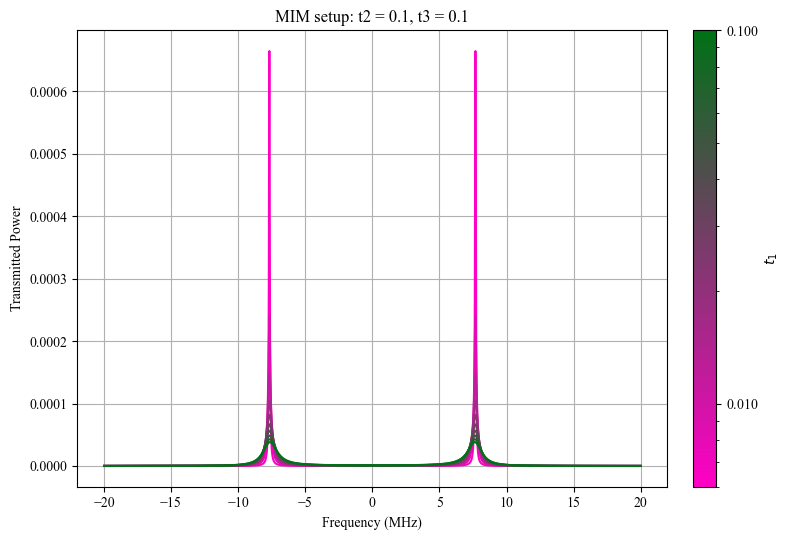

In [24]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case

# Parameter sweep
laser_freq = 2.8195e14
nu_range = np.linspace(-20e6, 20e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))

t_arr = np.linspace(6000e-6, 0.1, 10)

# Color normalization and colorbar for nanometers
norm = LogNorm(vmin=t_arr.min(), vmax=t_arr.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, t in enumerate(t_arr):
    mirror_vals = {t1: t, t2: 0.1, t3: 1e-6}
    subs_dict_num = {L1: 1, delta1: 0, L2: 1, delta2: 0}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values, _, _= cavity.transmitted_power([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values), color=colors[idx])

# ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
ax.set_title("MIM setup: t2 = 0.1, t3 = 0.1")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$t_1$")

plt.tight_layout()
plt.grid(which="both")
# plt.xlim(400+2.8195e8, 600+2.8195e8)
# plt.ylim(0, 0.000035)
# plt.savefig("transmission_MAME_dl.svg", transparent=True, dpi=300)
plt.show()

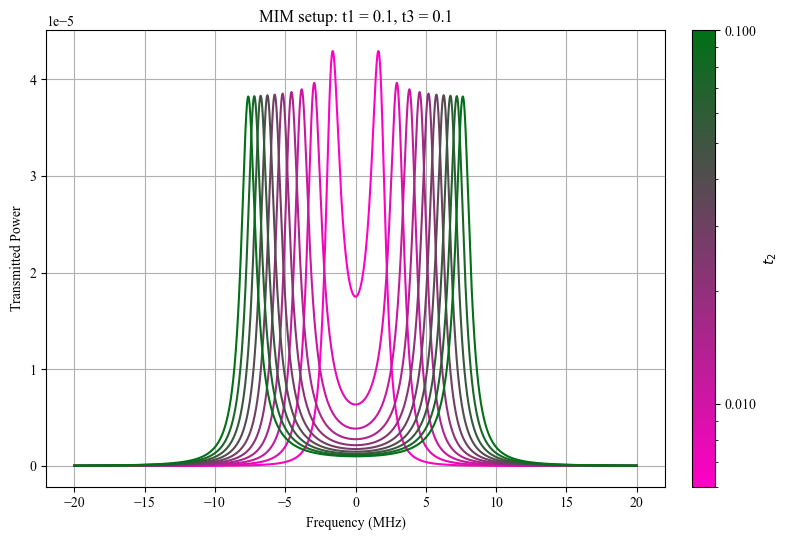

In [74]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case

# Parameter sweep
laser_freq = 2.8195e14
nu_range = np.linspace(-20e6, 20e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))

t_arr = np.linspace(6000e-6, 0.1, 10)

# Color normalization and colorbar for nanometers
norm = LogNorm(vmin=t_arr.min(), vmax=t_arr.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, t in enumerate(t_arr):
    mirror_vals = {t1: 0.1, t2: t, t3: 1e-6}
    subs_dict_num = {L1: 1, delta1: 0, L2: 1, delta2: 0}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values, _, _= cavity.transmitted_power([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6, np.abs(values), color=colors[idx])

# ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
ax.set_title("MIM setup: t1 = 0.1, t3 = 0.1")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$t_2$")

plt.tight_layout()
plt.grid(which="both")
# plt.xlim(400+2.8195e8, 600+2.8195e8)
# plt.ylim(0, 0.000035)
# plt.savefig("transmission_MAME_dl.svg", transparent=True, dpi=300)
plt.show()

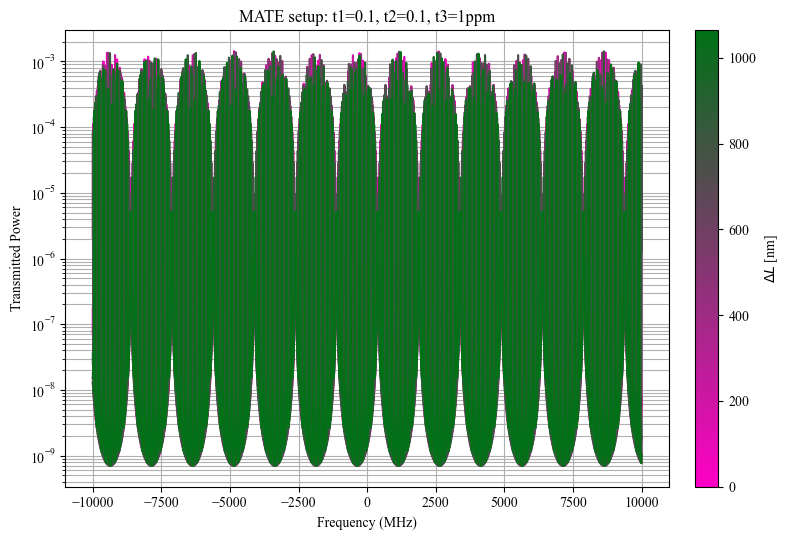

In [225]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case
mirror_vals = {t1: 0.1, t2: 0.1, t3: 1e-6}

length_subcavity_1 = make_length_resonant(0.1, 1064e-9)
length_subcavity_2 = make_length_resonant(0.9, 1064e-9)

# Parameter sweep
dL = np.linspace(0, 1064e-9, 10)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-10000e6, laser_freq+10000e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm

# Color normalization and colorbar for nanometers
norm = mcolors.Normalize(vmin=dL_nm.min(), vmax=dL_nm.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
fwhm_arr = []

colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, d in enumerate(dL):
    subs_dict_num = {L1: length_subcavity_1, delta1: 0, L2: length_subcavity_2, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values= cavity.transmitted_power_no_comp([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values), color=colors[idx])
    # Convert frequency to MHz for easier window definition
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000

    # Apply mask for the window you're interested in
    window_mask = (frequencies_mhz >= 275) & (frequencies_mhz <= 450)

    # Select the cropped data
    frequencies_window = ranges[window_mask]
    values_window = np.abs(values)[window_mask]

    # Now find the approximate peak in this window
    peak_idx = np.argmax(values_window)
    resonance_guess = frequencies_window[peak_idx]

    # Use your existing function (in original frequency units)
    # fwhm, right, left = find_fwhm(frequencies_window, values_window, resonance_guess)

    # Convert FWHM to MHz for display
    # fwhm_mhz = fwhm / (2 * np.pi) * 1e-6
    # fwhm_arr.append(fwhm_mhz)

ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
ax.set_title("MATE setup: t1=0.1, t2=0.1, t3=1ppm")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$\Delta L$ [nm]")

plt.tight_layout()
plt.grid(which="both")
# plt.xlim(275, 450)
# plt.ylim(0, 0.000035)
# plt.savefig("transmission_MAME_dl.svg", transparent=True, dpi=300)
plt.show()

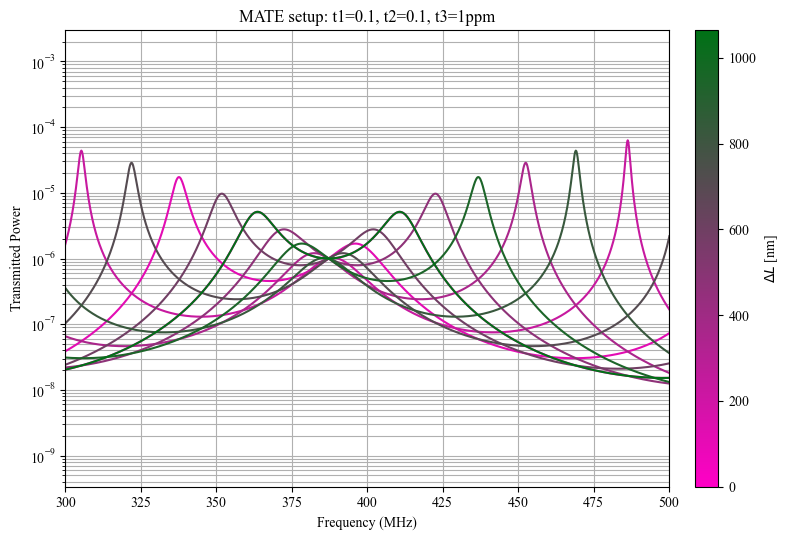

In [205]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case
mirror_vals = {t1: 0.1, t2: 0.1, t3: 1e-6}

length_subcavity_1 = make_length_resonant(0.1, 1064e-9)
length_subcavity_2 = make_length_resonant(0.9, 1064e-9)

# Parameter sweep
dL = np.linspace(0, 1064e-9, 10)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-10000e6, laser_freq+10000e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm

# Color normalization and colorbar for nanometers
norm = mcolors.Normalize(vmin=dL_nm.min(), vmax=dL_nm.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
fwhm_arr = []

colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, d in enumerate(dL):
    subs_dict_num = {L1: length_subcavity_1, delta1: 0, L2: length_subcavity_2, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values= cavity.transmitted_power_no_comp([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values), color=colors[idx])
    # Convert frequency to MHz for easier window definition
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000

ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
ax.set_title("MATE setup: t1=0.1, t2=0.1, t3=1ppm")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$\Delta L$ [nm]")

plt.tight_layout()
plt.grid(which="both")
plt.xlim(300, 500)
# plt.ylim(0, 0.000035)
# plt.savefig("transmission_MAME_dl.svg", transparent=True, dpi=300)
plt.show()

In [ ]:
resonant_freqs_mhz = []  # List to store resonant frequencies in MHz
dL = np.linspace(0, 1064e-9, 100)

for idx, d in enumerate(dL):
    subs_dict_num = {L1: length_subcavity_1, delta1: 0, L2: length_subcavity_2, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values = cavity.transmitted_power_no_comp([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values))
    
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000
    window_mask = (frequencies_mhz >= 275) & (frequencies_mhz <= 500)
    
    frequencies_window = ranges[window_mask]
    values_window = np.abs(values)[window_mask]
    
    peak_idx = np.argmax(values_window)
    resonance_guess = frequencies_window[peak_idx]
    
    # Save resonance frequency in MHz
    resonance_mhz = resonance_guess / (2 * np.pi) * 1e-6
    resonant_freqs_mhz.append(resonance_mhz)

    fwhm, right, left = find_fwhm(frequencies_window, values_window, resonance_guess)
    fwhm_mhz = fwhm / (2 * np.pi) * 1e-6
    fwhm_arr.append(fwhm_mhz)


In [224]:
leftmost_resonant_freqs_mhz = []

for idx, d in enumerate(dL):
    subs_dict_num = {L1: length_subcavity_1, delta1: 0, L2: length_subcavity_2, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values = cavity.transmitted_power_no_comp([nu_range])
    
    # Convert to MHz
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000
    
    # Apply mask to limit search range
    window_mask = (frequencies_mhz >= 300) & (frequencies_mhz <= 500)
    f_window = frequencies_mhz[window_mask]
    v_window = np.abs(values)[window_mask]

    # Find peaks
    peak_indices, _ = find_peaks(v_window)

    if len(peak_indices) > 0:
        leftmost_freq = f_window[peak_indices[0]]
        leftmost_resonant_freqs_mhz.append(leftmost_freq)
    else:
        leftmost_resonant_freqs_mhz.append(np.nan)  # or skip if you prefer

KeyboardInterrupt: 

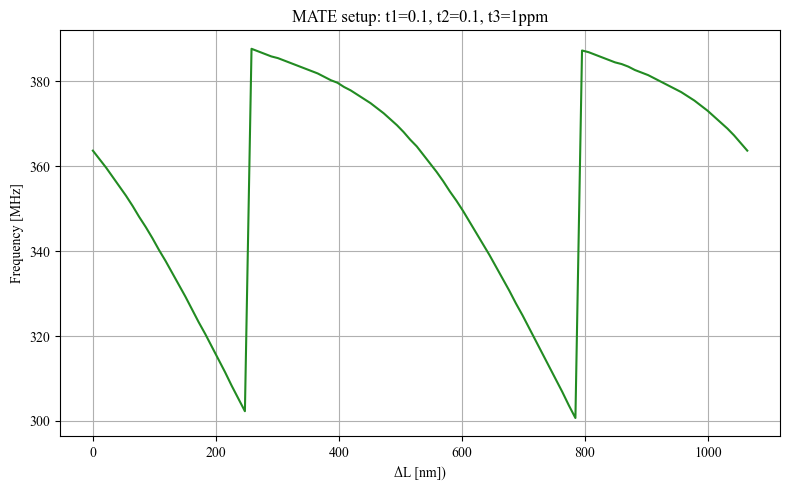

In [223]:
plt.figure(figsize=(8, 5))
plt.plot(dL * 1e9, leftmost_resonant_freqs_mhz, c = "forestgreen")
plt.xlabel("ΔL [nm])")
plt.ylabel("Frequency [MHz]")
plt.title("MATE setup: t1=0.1, t2=0.1, t3=1ppm")
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 0, '$\\Delta L$ [nm]')

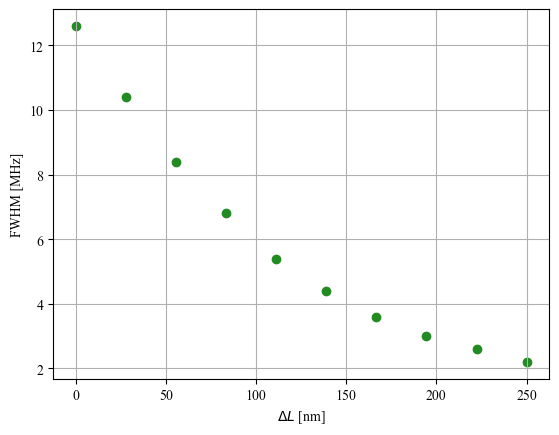

In [113]:
plt.scatter(dL*1e9, fwhm_arr, c = "forestgreen")
plt.grid()
plt.ylabel("FWHM [MHz]")
plt.xlabel(r"$\Delta L$ [nm]")

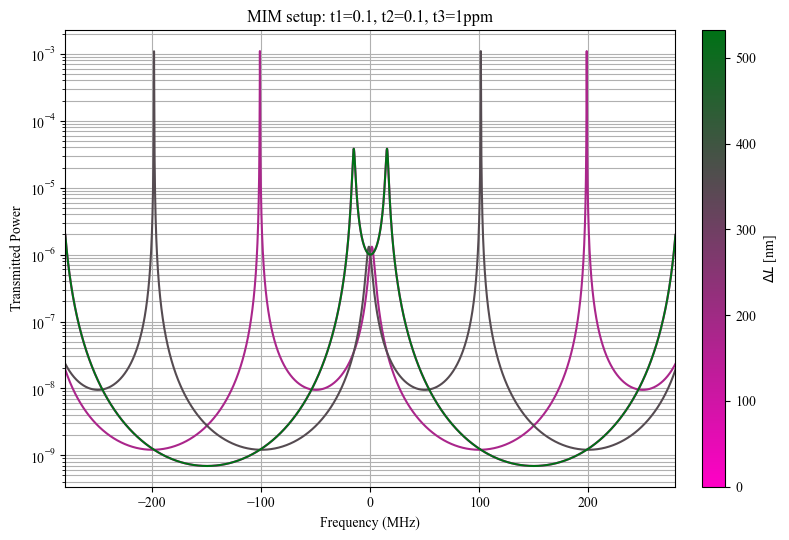

In [248]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case
mirror_vals = {t1: 0.1, t2: 0.1, t3: 1e-6}

# Parameter sweep
dL = np.linspace(0, 532e-9, 4)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-1500e6, laser_freq+1500e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm

# Color normalization and colorbar for nanometers
norm = mcolors.Normalize(vmin=dL_nm.min(), vmax=dL_nm.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])


colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, d in enumerate(dL):
    subs_dict_num = {L1: 0.5, delta1: 0, L2: 0.5, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values= cavity.transmitted_power_no_comp([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6 - 2.8196e8 + 9500, np.abs(values), color=colors[idx])

ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
ax.set_title("MIM setup: t1=0.1, t2=0.1, t3=1ppm")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$\Delta L$ [nm]")

plt.tight_layout()
plt.grid(which="both")
plt.xlim(-280, 280)
plt.show()

In [256]:
print(dL)

[0.00000000e+00 1.77333333e-07 3.54666667e-07 5.32000000e-07]


In [263]:
leftmost_resonant_freqs_mhz = []
dL = np.linspace(0, 532e-9, 100)
for idx, d in enumerate(dL):
    subs_dict_num = {L1: 0.5, delta1: 0, L2: 0.5, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values = cavity.transmitted_power_no_comp([nu_range])
    
    # Convert to MHz
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.8196e8 + 9500
    
    # Apply mask to limit search range
    window_mask = (frequencies_mhz >= -150) & (frequencies_mhz <= 150)
    f_window = frequencies_mhz[window_mask]
    v_window = np.abs(values)[window_mask]

    # Find peaks
    peak_indices, _ = find_peaks(v_window)

    if len(peak_indices) > 0:
        leftmost_freq = f_window[peak_indices[0]]
        leftmost_resonant_freqs_mhz.append(leftmost_freq)
    else:
        leftmost_resonant_freqs_mhz.append(np.nan)  # or skip if you prefer

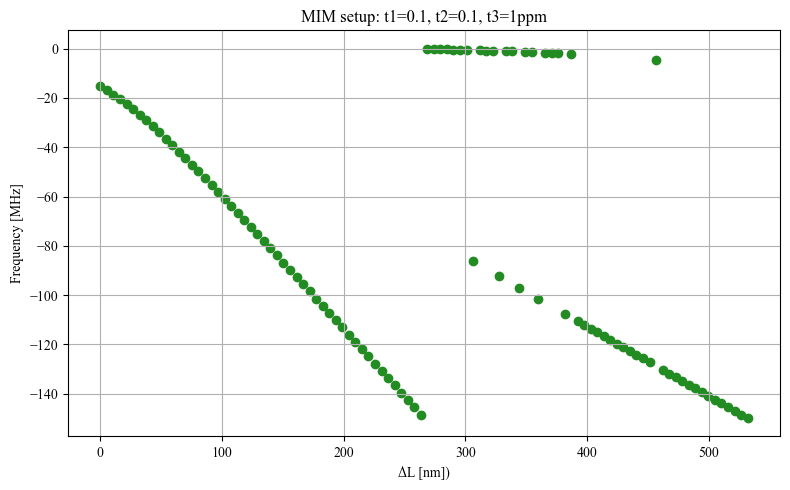

In [265]:
plt.figure(figsize=(8, 5))
plt.scatter(dL * 1e9, leftmost_resonant_freqs_mhz, c = "forestgreen")
plt.xlabel("ΔL [nm])")
plt.ylabel("Frequency [MHz]")
plt.title("MIM setup: t1=0.1, t2=0.1, t3=1ppm")
plt.grid(True)
plt.tight_layout()
plt.show()


### phase

In [76]:
t1, t2, t3 = symbols("t1 t2 t3")

length1 = make_length_resonant(0.5, 1064e-9)
length2 = make_length_resonant(1, 1064e-9)

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts = [t1, t2, t3]
lambdify_vars = [omega]
mirror_vals = {t1: 4000e-6, t2: 1000e-6, t3: 1e-6}
nu_range = np.linspace(-70e6, 70e6, 1000000)
subs_dict_num = {L1: 0.5-1e-3, delta1: 0, L2: 1e-3, delta2: 0}
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)

In [77]:
transmitted_range, transmitted_phase, _ = cavity.phase_response([nu_range])
reflected_range, reflected_phase, _ = cavity.phase_response_reflected([nu_range])
ranges, values, _, _ = cavity.transmitted_power([nu_range])

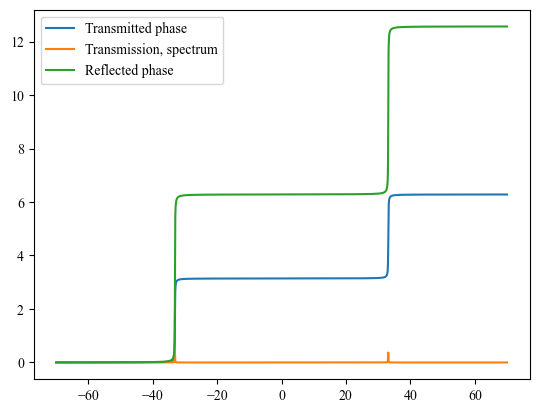

In [78]:
reflected_phase_shifted = (reflected_phase + np.pi) % (2 * np.pi) - np.pi
reflected_phase_unwrapped = np.unwrap(reflected_phase_shifted)


plt.plot(transmitted_range / (2 * np.pi) * 1e-6, np.unwrap(transmitted_phase) - np.pi/2, label = "Transmitted phase")
plt.plot(ranges/ (2 * np.pi) * 1e-6, values, label = "Transmission, spectrum")
plt.plot(reflected_range/ (2 * np.pi) * 1e-6, np.unwrap(reflected_phase) + np.pi, label = "Reflected phase")
plt.legend()

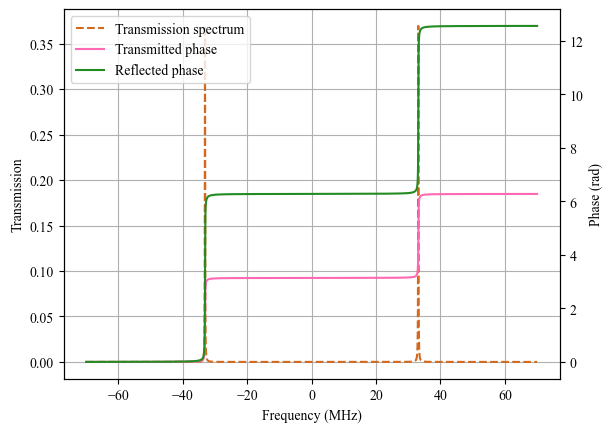

In [79]:
fig, ax1 = plt.subplots()

# Left y-axis: Transmission spectrum
ax1.plot(transmitted_range / (2 * np.pi) * 1e-6, values, label="Transmission spectrum", color='chocolate', linestyle = "dashed")
ax1.set_ylabel("Transmission")
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Right y-axis: Phase responses
ax2.plot(transmitted_range / (2 * np.pi) * 1e-6, np.unwrap(transmitted_phase) - np.pi/2, label="Transmitted phase", color='hotpink')
ax2.plot(reflected_range / (2 * np.pi) * 1e-6, np.unwrap(reflected_phase) + np.pi, label="Reflected phase", color='forestgreen')
ax2.set_ylabel("Phase (rad)")
ax2.tick_params(axis='y')

# Add legend: handle legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

ax1.grid()
ax1.set_xlabel("Frequency (MHz)")
plt.show()

In [80]:
laser_freq = 2.8195e14
nu_range_new = np.linspace(laser_freq - 5000e6, laser_freq + 5000e6, 100000)
folded_range, folded_phase = cavity.folded_spectrum_reflected_no_comp([nu_range_new], 2e6)
folded_range1, folded_phase1 = cavity.folded_spectrum_reflected([nu_range], 2e6)

reflected_phase_range, reflected_phase, _ = cavity.phase_response_reflected_no_comp([nu_range_new])

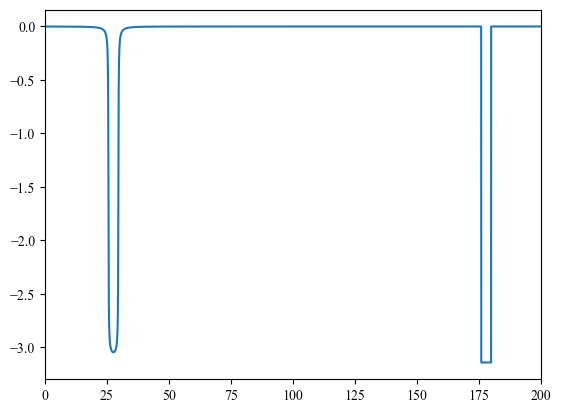

In [83]:
plt.plot(folded_range / (2 * np.pi) * 1e-6 - 4.4873e7 - 720, np.unwrap(folded_phase, discont= np.pi/4))
plt.xlim(0, 200)

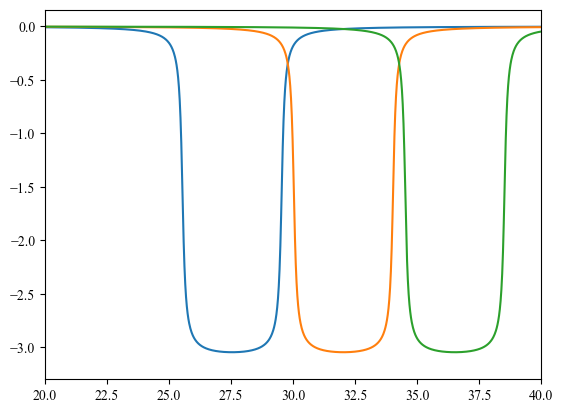

In [86]:
dL = np.linspace(1e-3, 1e-3+100e-9, 3)

for delta_L in dL:
    subs_dict_num = {L1: 0.5-delta_L, delta1: 0, L2: delta_L, delta2: 0}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    folded_range, folded_phase = cavity.folded_spectrum_reflected_no_comp([nu_range_new], 2e6)
    plt.plot(folded_range / (2 * np.pi) * 1e-6 - 4.4873e7 - 720, np.unwrap(folded_phase, discont= np.pi/4))

plt.xlim(20, 40)

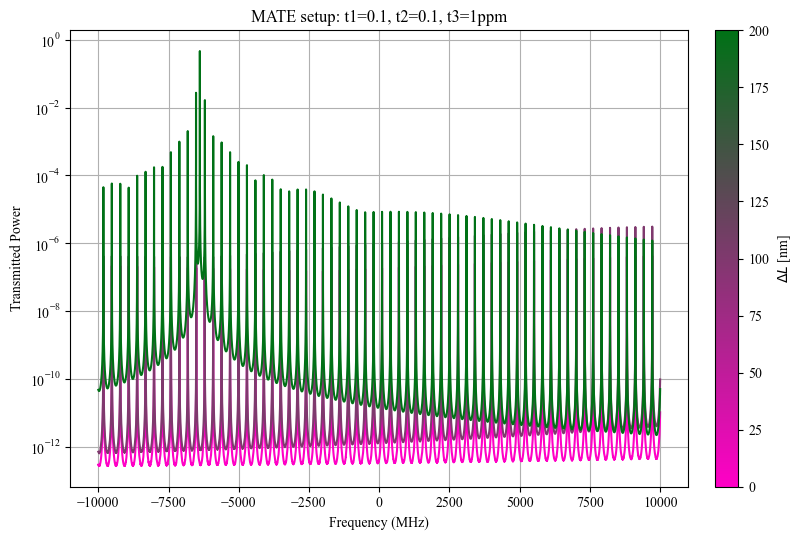

In [100]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case
mirror_vals = {t1: 4000e-6, t2: 1000e-6, t3: 1e-6}

length_subcavity_1 = make_length_resonant(0.5 - 1e-3, 1064e-9)
length_subcavity_2 = make_length_resonant(1e-3, 1064e-9)

# Parameter sweep
dL = np.linspace(0, 200e-9, 3)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-10000e6, laser_freq+10000e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm

# Color normalization and colorbar for nanometers
norm = mcolors.Normalize(vmin=dL_nm.min(), vmax=dL_nm.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])


colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, d in enumerate(dL):
    subs_dict_num = {L1: 0.5 - 1e-3, delta1: 0, L2: 1e-3, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values= cavity.transmitted_power_no_comp([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values), color=colors[idx])

# ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
ax.set_title("MATE setup: t1=0.1, t2=0.1, t3=1ppm")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$\Delta L$ [nm]")

plt.tight_layout()
plt.yscale("log")
plt.grid(which="both")
# plt.xlim(-7500, -5000)
# plt.ylim(0, 0.000035)
# plt.savefig("transmission_MAME_dl.svg", transparent=True, dpi=300)
plt.show()

In [176]:
t1, t2, t3 = symbols("t1 t2 t3")

length1 = make_length_resonant(0.5, 1064e-9)
length2 = make_length_resonant(1, 1064e-9)

L, delta, omega, L1, L2, delta1, delta2 = symbols("L delta omega L1 L2 delta1 delta2")
subs_dict = [{L: L1, delta: delta1}, {L: L2, delta: delta2}]
mirror_ts = [t1, t2, t3]
lambdify_vars = [omega]
mirror_vals = {t1: 0.01, t2: 0.1, t3: 0.01}
nu_range = np.linspace(-150e6, 150e6, 100000)

res_position_left = []
res_position_right = []
dL_range = np.linspace(-750e-9, 750e-9, 100)
for dL in dL_range:
    subs_dict_num = {L1: 0.5, delta1: dL, L2: 0.5, delta2: 0}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values, res_1, res_2  = cavity.transmitted_power([nu_range])
    res_position_left.append(res_1 / (2 * np.pi) * 1e-6)
    res_position_right.append(res_2 / (2 * np.pi) * 1e-6)

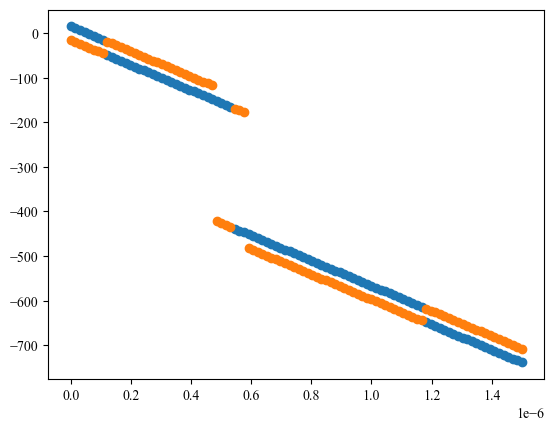

In [175]:
plt.scatter(dL_range, res_position_left)
plt.scatter(dL_range, res_position_right)

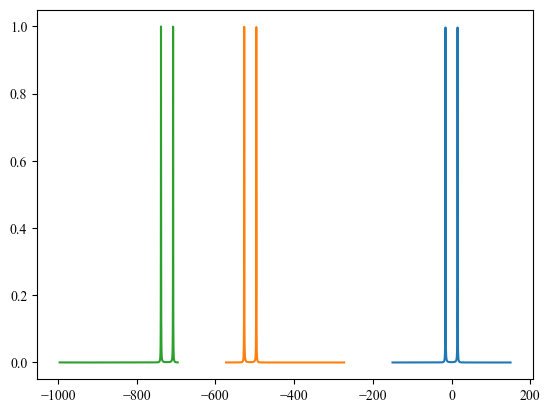

In [173]:
nu_range = np.linspace(-150e6, 150e6, 10000)
dL_range = np.linspace(0, 1500e-9, 3)
for dL in dL_range:
    subs_dict_num = {L1: 0.5, delta1: dL, L2: 0.5, delta2: 0}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values, res_1, res_2  = cavity.transmitted_power([nu_range])
    plt.plot(ranges / (2 * np.pi) * 1e-6, values)

In [ ]:
omega, delta1, delta2, L1, L2 = symbols("omega delta1 delta2 L1 L2")
mirror_tr = [0.1, 0.1, 0.1]
subs_dict = [
    {L: L1, delta: delta1},  
    {L: L2, delta: delta2}   
]


cavity_sym = Cavity_sym(mirror_tr, subs_dict)

transmitted_power = cavity_sym.transmitted_power
transmitted_power_expr = transmitted_power()


substitutions = {
    L1: 0.5,
    delta1: 0,
    L2: 0.5,
    omega:2 * np.pi * 299_792_458 / 1064e-9
}
omega_0 = 3e8/1064e-9 * (2 * np.pi) 
subbed_expr = transmitted_power_expr.subs(substitutions)

function = sp.lambdify(delta2, subbed_expr)
delta2_vals = np.linspace(-1500e-9, 1500e-9, 1000000)


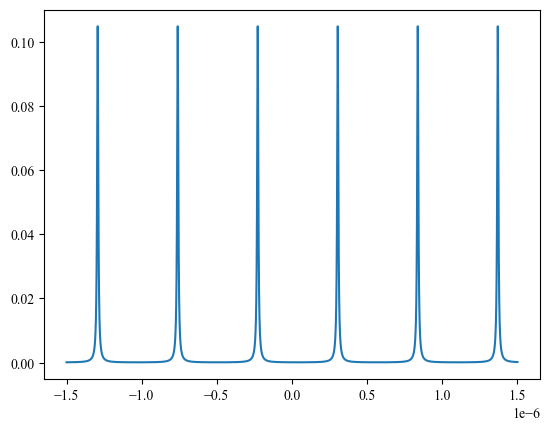

In [ ]:
power_values = function(delta2_vals)
plt.plot(delta2_vals, power_values)

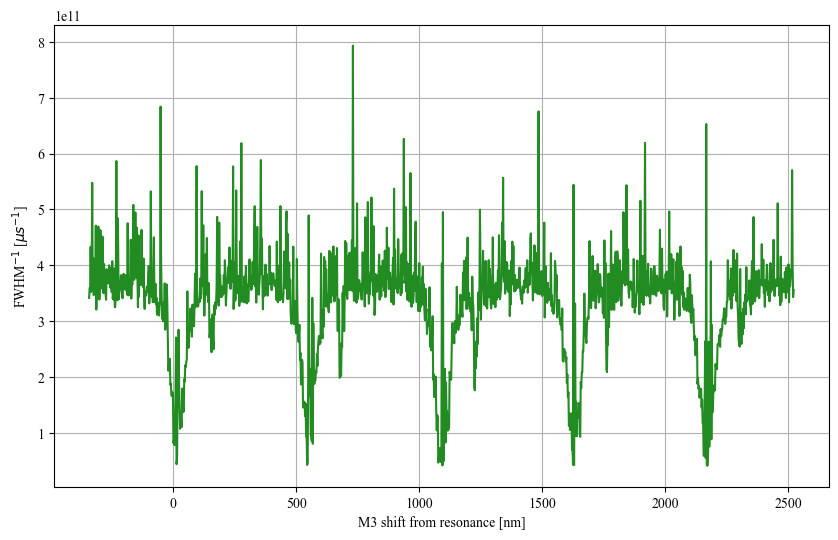

In [483]:
import pandas as pd


file_path = r"C:\Users\HP\Desktop\m1 internship\FWHM_VS_TIME.txt"

df = pd.read_csv(file_path, delim_whitespace=True, skiprows=5, names=["Time", "FWHM"], comment="#", engine="python")


df = df[pd.to_numeric(df["Time"], errors="coerce").notnull()]
df = df.astype(float)

df_subset = df.iloc[3100:4471]
plt.figure(figsize=(10, 6))
fwhm_time = df_subset["FWHM"]  
fwhm_hz = 1/(fwhm_time)  
plt.plot((df_subset["Time"] * 2.09e-9 - 7.26e-6) * 1e9, fwhm_hz * 1e6, c = "forestgreen")
plt.xlabel("M3 shift from resonance [nm]")
plt.ylabel(r"FWHM$^{-1}$ [$\mu s^{-1}$]")
plt.grid(True)
# plt.xlim(0, 200)
plt.show()

#check if the width of the curve is the same

Fitted center: 1079.10 nm
Fitted FWHM: 51.52 nm


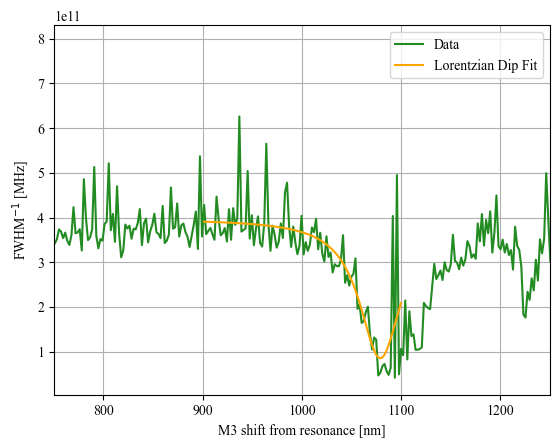

In [472]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Invert FWHM to get Hz, as you did
x_vals = (df_subset["Time"] * 2.09e-9 - 7.26e-6) * 1e9  # in nm
y_vals = (1 / df_subset["FWHM"]) * 1e6  # in MHz

# Select the dip region (example: around 1000 nm)
mask = (x_vals > 900) & (x_vals < 1100)
x_dip = x_vals[mask].values
y_dip = y_vals[mask].values

# Define Lorentzian dip function
def lorentzian_dip(x, A, x0, gamma, C):
    return C - A * gamma**2 / ((x - x0)**2 + gamma**2)

# Estimate initial parameters
A0 = np.max(y_dip) - np.min(y_dip)
x0_0 = x_dip[np.argmin(y_dip)]
gamma0 = 20  # initial guess for HWHM
C0 = np.max(y_dip)
p0 = [A0, x0_0, gamma0, C0]

# Fit
popt, pcov = curve_fit(lorentzian_dip, x_dip, y_dip, p0=p0)
A_fit, x0_fit, gamma_fit, C_fit = popt
fwhm_nm = 2 * gamma_fit

print(f"Fitted center: {x0_fit:.2f} nm")
print(f"Fitted FWHM: {fwhm_nm:.2f} nm")

# Plot
plt.plot(x_vals, y_vals, label="Data", color="forestgreen")
plt.plot(x_dip, lorentzian_dip(x_dip, *popt), color="orange", label="Lorentzian Dip Fit")
plt.xlabel("M3 shift from resonance [nm]")
plt.ylabel(r"FWHM$^{-1}$ [MHz]")
plt.legend()
plt.grid(True)
plt.xlim(750, 1250)
plt.show()


In [478]:
omega, delta1, delta2, L1, L2 = symbols("omega delta1 delta2 L1 L2")
mirror_tr = [0.1, 0.1, 0.1]
subs_dict = [
    {L: L1, delta: delta1},  
    {L: L2, delta: delta2}   
]


cavity_sym = Cavity_sym(mirror_tr, subs_dict)
def make_length_resonant(input_length, wavelength):
    m = round(2 * input_length / wavelength)
    resonant_length = m * (wavelength / 2)
    return resonant_length
def make_length_antiresonant(input_length, wavelength):
    quarter_lambda = wavelength / 4
    # compute the index n such that L = n * quarter_lambda, where n is odd
    n = round(input_length / quarter_lambda)

    # ensure n is odd
    if n % 2 == 0:
        # choose the closer odd number
        n_up = n + 1
        n_down = n - 1
        if abs(n_up * quarter_lambda - input_length) < abs(n_down * quarter_lambda - input_length):
            n = n_up
        else:
            n = n_down

    return n * quarter_lambda


transmitted_power = cavity_sym.transmitted_power
transmitted_power_expr = transmitted_power()
length_res = make_length_resonant(0.5, 1064e-9)
length_antires = make_length_antiresonant(0.5, 1064e-9)

substitutions = {
    L1: length_res,
    delta1: 0,
    L2: length_res ,
    omega:2 * np.pi * 299_792_458 / 1064e-9
}
omega_0 = 3e8/1064e-9 * (2 * np.pi) 
subbed_expr = transmitted_power_expr.subs(substitutions)



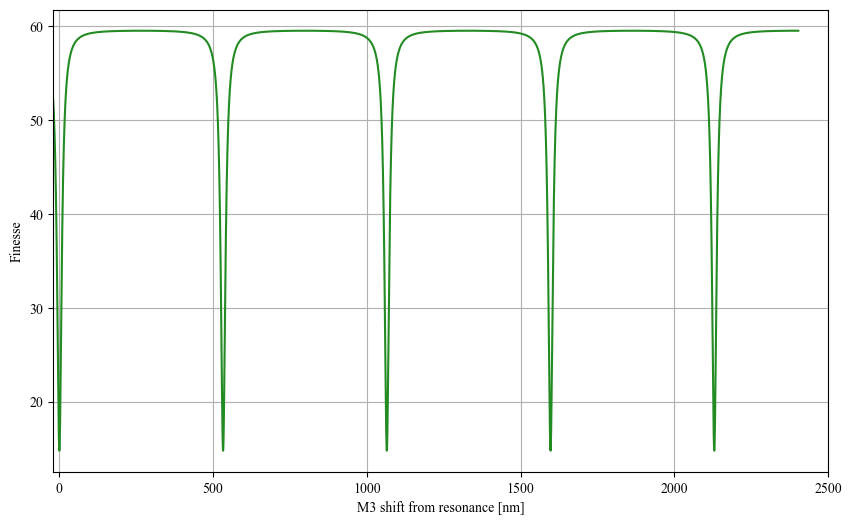

In [484]:
function = sp.lambdify(delta2, subbed_expr)
delta2_vals = np.linspace(-1500e-9, 2500e-9, 1000000)
plt.figure(figsize=(10, 6))
power_values = function(delta2_vals)
reflected_power = 1-power_values
finesse = (2 * np.pi) / (- np.log(reflected_power * 0.9))
# finesse = (np.pi * np.sqrt(reflected_power * 0.84)) / (1 - reflected_power * 0.84)
plt.plot(delta2_vals * 1e9 - 97, finesse, c = "forestgreen")
plt.xlabel("M3 shift from resonance [nm]")
plt.ylabel("Finesse")
plt.grid()
plt.xlim(-20, 2500)

FWHM of the dip around 500 nm: 24.00 nm


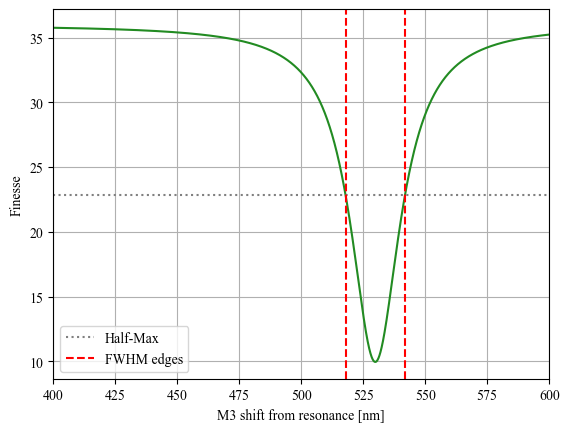

In [476]:


# Recompute finesse if needed
# finesse = (2 * np.pi) / (- np.log(reflected_power * 0.9))
x = delta2_vals * 1e9 - 97  # M3 shift [nm]
y = finesse

# Focus on first dip around 500 nm (adjust as needed)
mask = (x > 400) & (x < 600)
x_crop = x[mask]
y_crop = y[mask]

# Find min (dip) and half-max
y_min = np.min(y_crop)
y_max = np.max(y_crop)
half_max = (y_max + y_min) / 2

# Find points where curve crosses half-max
above = y_crop > half_max
crossings = np.where(np.diff(above.astype(int)) != 0)[0]

# Interpolate to find exact crossing points
from scipy.interpolate import interp1d

f_interp = interp1d(x_crop, y_crop - half_max)
x1 = float(np.linspace(x_crop[crossings[0]], x_crop[crossings[0]+1], 1000)[np.argmin(np.abs(f_interp(np.linspace(x_crop[crossings[0]], x_crop[crossings[0]+1], 1000))))])
x2 = float(np.linspace(x_crop[crossings[1]], x_crop[crossings[1]+1], 1000)[np.argmin(np.abs(f_interp(np.linspace(x_crop[crossings[1]], x_crop[crossings[1]+1], 1000))))])
fwhm = x2 - x1

print(f"FWHM of the dip around 500 nm: {fwhm:.2f} nm")

# Plot with FWHM markers
plt.plot(x, y, color="forestgreen")
plt.axhline(half_max, color="gray", linestyle=":", label="Half-Max")
plt.axvline(x1, color="red", linestyle="--", label="FWHM edges")
plt.axvline(x2, color="red", linestyle="--")
plt.xlabel("M3 shift from resonance [nm]")
plt.ylabel("Finesse")
plt.xlim(400, 600)
plt.legend()
plt.grid(True)
plt.show()


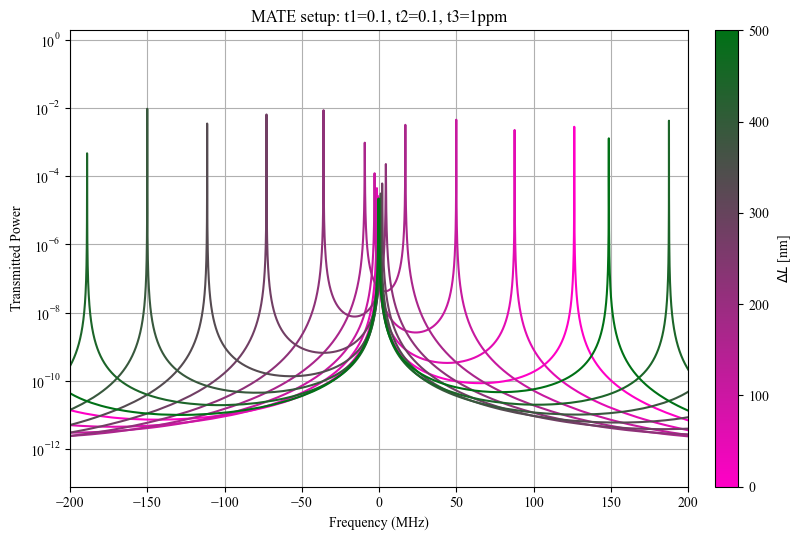

In [340]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ff00c6", "#007116"])

# Mirror values – keeping only the first case
mirror_vals = {t1: 0.0005, t2: 0.01, t3: 1e-6}

length_subcavity_1 = make_length_resonant(0.1, 1064e-9)
length_subcavity_2 = make_length_resonant(0.9, 1064e-9)

# Parameter sweep
dL = np.linspace(0, 500e-9, 10)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-1000e6, laser_freq+1000e6, 100000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm

# Color normalization and colorbar for nanometers
norm = mcolors.Normalize(vmin=dL_nm.min(), vmax=dL_nm.max())
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
fwhm_arr = []

colors = custom_cmap(np.linspace(0, 1, len(dL)))
for idx, d in enumerate(dL):
    subs_dict_num = {L1: 0.09, delta1: 0, L2: 0.4, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values= cavity.transmitted_power_no_comp([nu_range])
    ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values), color=colors[idx])
    # Convert frequency to MHz for easier window definition
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000

    # Apply mask for the window you're interested in
    window_mask = (frequencies_mhz >= 275) & (frequencies_mhz <= 450)

    # Select the cropped data
    frequencies_window = ranges[window_mask]
    values_window = np.abs(values)[window_mask]

    # Now find the approximate peak in this window
    peak_idx = np.argmax(values_window)
    resonance_guess = frequencies_window[peak_idx]

    # Use your existing function (in original frequency units)
    # fwhm, right, left = find_fwhm(frequencies_window, values_window, resonance_guess)

    # Convert FWHM to MHz for display
    # fwhm_mhz = fwhm / (2 * np.pi) * 1e-6
    # fwhm_arr.append(fwhm_mhz)

# ax.set_yscale("log")
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Transmitted Power")
ax.set_title("MATE setup: t1=0.1, t2=0.1, t3=1ppm")

# Colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.set_label(r"$\Delta L$ [nm]")

plt.tight_layout()
plt.yscale("log")
plt.grid(which="both")
plt.xlim(-200, 200)
# plt.ylim(0, 0.00025)
plt.show()

0.04000037908554077
0.04000037908554077
0.040000319480895996
0.06000065803527832
0.04000043869018555
0.060000598430633545
0.04000043869018555
0.040000319480895996
0.08000075817108154
0.04000043869018555


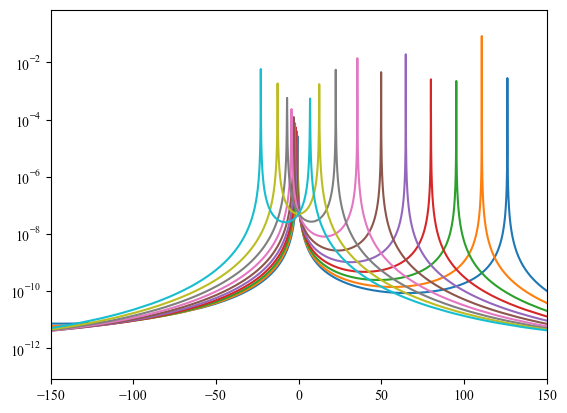

In [81]:
resonant_freqs_mhz = []  # List to store resonant frequencies in MHz
dL = np.linspace(0, 200e-9, 10)
fwhm_arr = []
mirror_vals = {t1: 0.0005, t2: 0.01, t3: 1e-6}
for idx, d in enumerate(dL):
    subs_dict_num = {L1: 0.09, delta1: 0, L2: 0.4, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values = cavity.transmitted_power_no_comp([nu_range])
    plt.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values))
    
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000
    window_mask = (frequencies_mhz >= -150) & (frequencies_mhz <= 150)
    
    frequencies_window = frequencies_mhz[window_mask]
    values_window = np.abs(values)[window_mask]
    
    peak_idx = np.argmax(values_window)
    resonance_guess = frequencies_window[peak_idx]
    
    # Save resonance frequency in MHz
    resonance_mhz = resonance_guess 
    resonant_freqs_mhz.append(resonance_mhz)

    fwhm, right, left = find_fwhm(frequencies_window, values_window, resonance_guess)
    fwhm_mhz = fwhm / (2 * np.pi) * 1e-6
    print(fwhm)
    fwhm_arr.append(fwhm_mhz)

plt.xlim(-150, 150)
plt.yscale("log")

6.3662675433873286e-09
6.366258057013482e-09
6.366258057013482e-09
6.3662675433873286e-09
6.3662675433873286e-09
6.366258057013482e-09
6.3662675433873286e-09
6.366258057013482e-09
6.3662675433873286e-09
6.366258057013482e-09


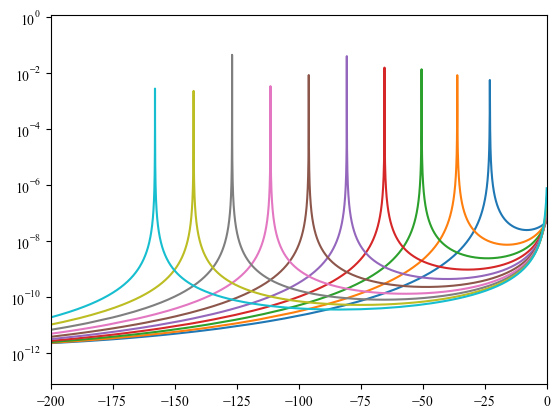

In [83]:
dL = np.linspace(200e-9, 400e-9, 10)

for idx, d in enumerate(dL):
    subs_dict_num = {L1: 0.09, delta1: 0, L2: 0.4, delta2: d}
    cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
    ranges, values = cavity.transmitted_power_no_comp([nu_range])
    plt.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values))
    
    frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000
    window_mask = (frequencies_mhz >= -200) & (frequencies_mhz <= 10)
    
    frequencies_window = frequencies_mhz[window_mask]
    values_window = np.abs(values)[window_mask]
    
    peak_idx = np.argmax(values_window)
    resonance_guess = frequencies_window[peak_idx]
    
    # Save resonance frequency in MHz
    resonance_mhz = resonance_guess / (2 * np.pi) * 1e-6
    resonant_freqs_mhz.append(resonance_mhz)

    fwhm, right, left = find_fwhm(frequencies_window, values_window, resonance_guess)
    fwhm_mhz = fwhm / (2 * np.pi) * 1e-6
    print(fwhm_mhz)
    fwhm_arr.append(fwhm_mhz)

plt.xlim(-200, 0)
plt.yscale("log")

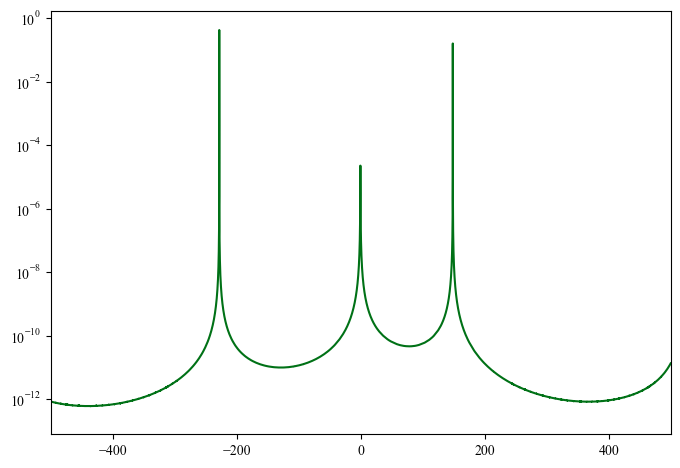

In [330]:
dL = np.linspace(200e-9, 400e-9, 10)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-1000e6, laser_freq+1000e6, 1000000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm


subs_dict_num = {L1: 0.09, delta1: 0, L2: 0.4, delta2:  5.00000000e-07}
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values= cavity.transmitted_power_no_comp([nu_range])
ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000, np.abs(values), color=colors[idx])
plt.xlim(-500, 500)
# plt.ylim(0, 0.1)
plt.yscale("log")

In [273]:
dL = np.linspace(0, 500e-9, 20)
print(dL)

[0.00000000e+00 2.63157895e-08 5.26315789e-08 7.89473684e-08
 1.05263158e-07 1.31578947e-07 1.57894737e-07 1.84210526e-07
 2.10526316e-07 2.36842105e-07 2.63157895e-07 2.89473684e-07
 3.15789474e-07 3.42105263e-07 3.68421053e-07 3.94736842e-07
 4.21052632e-07 4.47368421e-07 4.73684211e-07 5.00000000e-07]


In [331]:
frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000

    # Apply mask for the window you're interested in
window_mask = (frequencies_mhz >= -250) & (frequencies_mhz <= -100)

    # Select the cropped data
frequencies_window = ranges[window_mask]
values_window = np.abs(values)[window_mask]

    # Now find the approximate peak in this window
peak_idx = np.argmax(values_window)
resonance_guess = frequencies_window[peak_idx]

    # Use your existing function (in original frequency units)
fwhm, right, left = find_fwhm(frequencies_window, values_window, resonance_guess)

    # Convert FWHM to MHz for display
fwhm_mhz = fwhm / (2 * np.pi) * 1e-6

In [332]:
print(fwhm_mhz)

0.004000001395992833


In [485]:
fwhm_arr_2 = [0.13400014623759932, 0.13200012564523503, 0.13200012564523503, 0.1300001448416065, 0.12600014344561367, 0.12000012145725651, 0.09800013367366382, 0.05600001954389966, 0.024000008375956994, 0.012000004187978497, 0.008000002791985665, 0.005999982199621362, 0.004000001395992833, 0.004000001395992833, 0.006000021988357135, 0.005999982199621362, 0.004000001395992833, 0.004000001395992833, 0.004000001395992833, 0.004000001395992833]
fwhm_arr = [0.13400014623759932, 0.13200012564523503, 0.11600012006126369, 0.02600006875705707, 0.006000061777092908, 0.004000001395992833, 0.004000001395992833, 0.004000001395992833, 0.005999982199621362, 0.12800012424924218, 0.10000007468855658, 0.013999984991607026, 0.006000021988357135, 0.0039999616072570595, 0.004000001395992833, 0.13200012564523503, 0.13200008585649922, 0.12600014344561367, 0.06800006352061393, 0.009999983595614196, 0.005999982199621362, 0.006000061777092908, 0.004000001395992833, 0.13200012564523503, 0.1300001050528707, 0.12200006247214927, 0.036000052352671265, 0.006000021988357135, 0.006000061777092908, 0.004000001395992833]
shape(np.array(fwhm_arr_2))

In [487]:
print(min(fwhm_arr_2))

0.004000001395992833


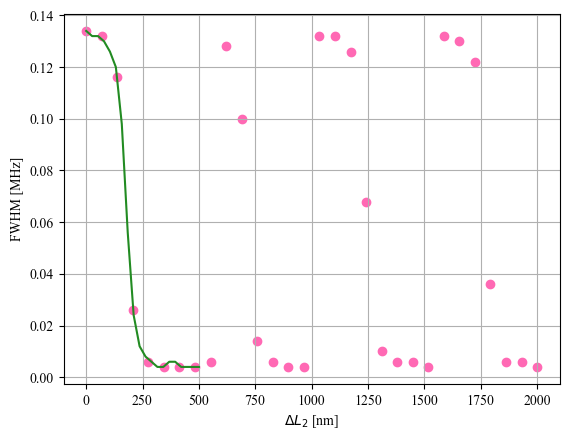

In [351]:
plt.scatter(np.linspace(0, 2000e-9, 30) * 1e9, fwhm_arr, c = "hotpink")
plt.plot(np.linspace(0, 500e-9, 20) * 1e9, fwhm_arr_2, c = "forestgreen")
plt.xlabel(r"$\Delta L_2$ [nm]")
plt.ylabel("FWHM [MHz]")
plt.grid()

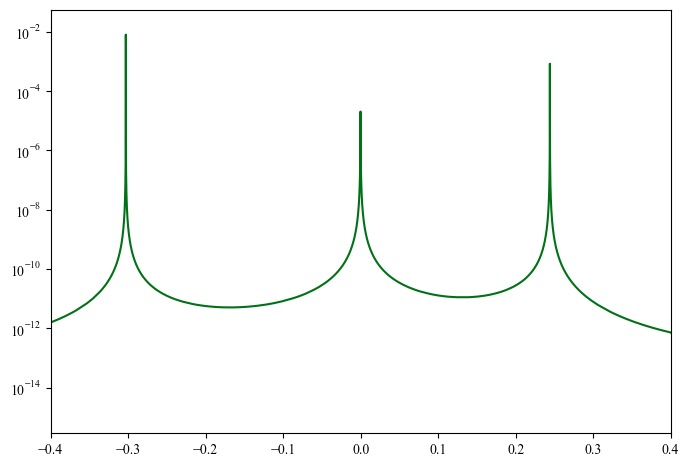

In [427]:
dL = np.linspace(200e-9, 400e-9, 10)
laser_freq = 2.8195e14
nu_range = np.linspace(laser_freq-10e6, laser_freq+10e6, 1000000)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 5.5))
dL_nm = dL * 1e9  # new array in nm
mirror_vals = {t1: 50e-6, t2: 0.001, t3: 1e-6}
subs_dict_num = {L1: 10, delta1: 0, L2: 274.9, delta2: 3.85241379e-07 }
cavity = Cavity_num(mirror_ts, mirror_vals, subs_dict, subs_dict_num, lambdify_vars)
ranges, values= cavity.transmitted_power_no_comp([nu_range])
ax.plot(ranges / (2 * np.pi) * 1e-6 -2.819e8 - 50000 - 5, np.abs(values), color=colors[idx])
plt.xlim(-0.4, 0.4)
# plt.ylim(0, 0.1)
plt.yscale("log")

In [359]:
dL = np.linspace(0, 532e-9, 30)
print(dL)

[0.00000000e+00 1.83448276e-08 3.66896552e-08 5.50344828e-08
 7.33793103e-08 9.17241379e-08 1.10068966e-07 1.28413793e-07
 1.46758621e-07 1.65103448e-07 1.83448276e-07 2.01793103e-07
 2.20137931e-07 2.38482759e-07 2.56827586e-07 2.75172414e-07
 2.93517241e-07 3.11862069e-07 3.30206897e-07 3.48551724e-07
 3.66896552e-07 3.85241379e-07 4.03586207e-07 4.21931034e-07
 4.40275862e-07 4.58620690e-07 4.76965517e-07 4.95310345e-07
 5.13655172e-07 5.32000000e-07]


In [425]:
frequencies_mhz = ranges / (2 * np.pi) * 1e-6 - 2.819e8 - 50000 - 5

    # Apply mask for the window you're interested in
window_mask = (frequencies_mhz >= -0.4) & (frequencies_mhz <= -0.1)

    # Select the cropped data
frequencies_window = ranges[window_mask]
values_window = np.abs(values)[window_mask]

    # Now find the approximate peak in this window

peak_idx = np.argmax(values_window)
resonance_guess = frequencies_window[peak_idx]

    # Use your existing function (in original frequency units)
fwhm, right, left = find_fwhm(frequencies_window, values_window, resonance_guess)

    # Convert FWHM to MHz for display
fwhm_mhz = fwhm / (2 * np.pi) * 1e-6

In [426]:
print(fwhm_mhz)

6.0001413545644544e-05


In [428]:
fwhm_arr = [0.00014001656118509492, 0.00013997677244932194, 0.00011996303835551611, 4.002746818761168e-05, 4.002746818761168e-05, 8.001514763945039e-05, 6.0001413545644544e-05, 4.002746818761168e-05, 3.99876794518387e-05, 5.996162480987157e-05, 3.99876794518387e-05, 6.0001413545644544e-05, 4.002746818761168e-05, 3.99876794518387e-05, 3.99876794518387e-05, 6.0001413545644544e-05, 6.0001413545644544e-05, 3.99876794518387e-05, 6.0001413545644544e-05, 3.99876794518387e-05, 6.0001413545644544e-05, ]

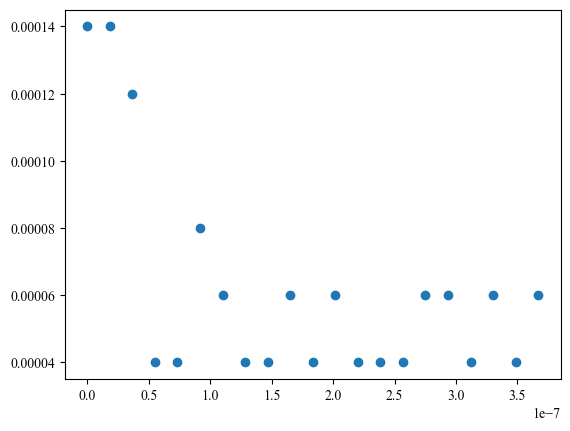

In [ ]:
plt.scatter([0.00000000e+00, 1.83448276e-08, 3.66896552e-08, 5.50344828e-08,
 7.33793103e-08, 9.17241379e-08, 1.10068966e-07, 1.28413793e-07,
 1.46758621e-07, 1.65103448e-07 ,1.83448276e-07 ,2.01793103e-07,
 2.20137931e-07, 2.38482759e-07 ,2.56827586e-07 ,2.75172414e-07,
 2.93517241e-07 ,3.11862069e-07 ,3.30206897e-07 ,3.48551724e-07,
 3.66896552e-07], fwhm_arr)

In [437]:
0.00014 - 0.00004